# OpenFlights Data

This notebook provides an alternative way to process this data for the analysis that is seen [in this dataquest.io post](https://www.dataquest.io/blog/python-data-visualization-libraries/).

## Pandas
Specifically, this makes greater use of functionality provided by read_csv, and then joins the data together similar to how you would for a regular [star schema](https://en.wikipedia.org/wiki/Star_schema).

![](http://i.imgur.com/puuLrR9.png)

This approach is widely used in analysis tools because it makes it easy to aggregate the values by one or more dimensions, and quickly change between how this is being performed. When following this approach, the bokeh chart library is much more easy to use.

## Bokeh
I am working on the Bokeh Charts refactor and noticed that this post made it look difficult to use the Bar chart, so this will show the intended use case.


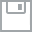
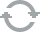
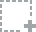
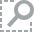
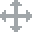
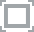
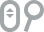
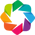
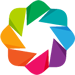
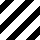
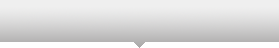
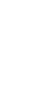
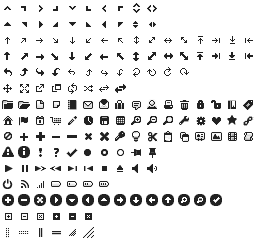
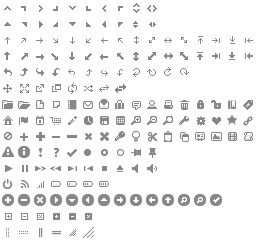
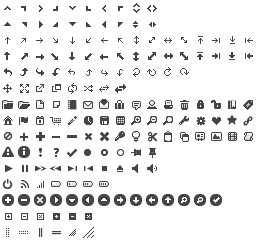
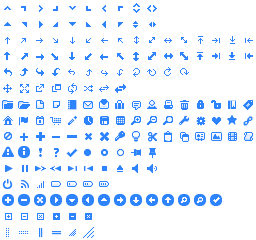
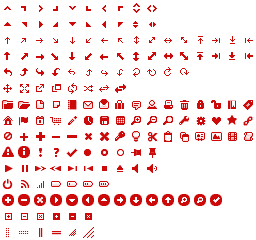
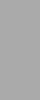

In [25]:
import numpy as np
import pandas as pd

from bokeh.io import output_notebook
from bokeh.charts import Bar, Scatter, show

output_notebook()

## Data Preparation
### Load the Data
Here, we can handle all the NA values and data index during the importing of the csv to avoid further processing

In [26]:
# Read in the airports data.
cols = ["name", "city", "country", "code", "icao", "latitude", "longitude", "altitude", "offset", "dst", "timezone"]
airports = pd.read_csv("airports.csv", header=None, names=cols, index_col=0, na_values='\N')

# Read in the airlines data.
cols = ["name", "alias", "iata", "icao", "callsign", "country", "active"]
airlines = pd.read_csv("airlines.csv", header=None, index_col=0, names=cols, na_values='\N')

# Read in the routes data.
cols = ["airline", "airline_id", "source", "source_id", "dest", "dest_id", "codeshare", "stops", "equipment"]
routes = pd.read_csv("routes.csv", header=None, names=cols, na_values='\N')


### Look at the Source Data

In [27]:
airports.head()

name          city           country code  icao  \
1                      Goroka        Goroka  Papua New Guinea  GKA  AYGA   
2                      Madang        Madang  Papua New Guinea  MAG  AYMD   
3                 Mount Hagen   Mount Hagen  Papua New Guinea  HGU  AYMH   
4                      Nadzab        Nadzab  Papua New Guinea  LAE  AYNZ   
5  Port Moresby Jacksons Intl  Port Moresby  Papua New Guinea  POM  AYPY   

   latitude   longitude  altitude  offset dst              timezone  
1 -6.081689  145.391881      5282      10   U  Pacific/Port_Moresby  
2 -5.207083  145.788700        20      10   U  Pacific/Port_Moresby  
3 -5.826789  144.295861      5388      10   U  Pacific/Port_Moresby  
4 -6.569828  146.726242       239      10   U  Pacific/Port_Moresby  
5 -9.443383  147.220050       146      10   U  Pacific/Port_Moresby

In [28]:
airlines.head()

name alias iata icao callsign  \
1                                Private flight   NaN    -  NaN      NaN   
2                                   135 Airways   NaN  NaN  GNL  GENERAL   
3                                 1Time Airline   NaN   1T  RNX  NEXTIME   
4  2 Sqn No 1 Elementary Flying Training School   NaN  NaN  WYT      NaN   
5                               213 Flight Unit   NaN  NaN  TFU      NaN   

          country active  
1             NaN      Y  
2   United States      N  
3    South Africa      Y  
4  United Kingdom      N  
5          Russia      N

In [29]:
routes.head()

airline  airline_id source  source_id dest  dest_id codeshare  stops  \
0      2B         410    AER       2965  KZN     2990       NaN      0   
1      2B         410    ASF       2966  KZN     2990       NaN      0   
2      2B         410    ASF       2966  MRV     2962       NaN      0   
3      2B         410    CEK       2968  KZN     2990       NaN      0   
4      2B         410    CEK       2968  OVB     4078       NaN      0   

  equipment  
0       CR2  
1       CR2  
2       CR2  
3       CR2  
4       CR2

### Join Data Associated with Each ID into Routes

In [30]:
routes = routes.merge(airports, left_on='dest_id', right_index=True, how='left')
routes = routes.merge(airports, left_on='source_id', right_index=True, how='left', suffixes=['_dest', '_source'])
routes = routes.merge(airlines, left_on='airline_id', right_index=True, how='left', suffixes=('', '_airline'))

### Final Joined Dataset to Use for Analysis

In [31]:
routes.head()

airline  airline_id source  source_id dest  dest_id codeshare  stops  \
0      2B         410    AER       2965  KZN     2990       NaN      0   
1      2B         410    ASF       2966  KZN     2990       NaN      0   
2      2B         410    ASF       2966  MRV     2962       NaN      0   
3      2B         410    CEK       2968  KZN     2990       NaN      0   
4      2B         410    CEK       2968  OVB     4078       NaN      0   

  equipment         name_dest  ...   offset_source dst_source  \
0       CR2             Kazan  ...               4          N   
1       CR2             Kazan  ...               4          N   
2       CR2  Mineralnyye Vody  ...               4          N   
3       CR2             Kazan  ...               6          N   
4       CR2        Tolmachevo  ...               6          N   

      timezone_source        name  alias  iata  icao    callsign   country  \
0       Europe/Moscow  Aerocondor    NaN    2B   ARD  AEROCONDOR  Portugal   
1       Europe/Moscow  Aerocondor    NaN    2B   ARD  AEROCONDOR  Portugal   
2       Europe/Moscow  Aerocondor    NaN    2B   ARD  AEROCONDOR  Portugal   
3  Asia/Yekaterinburg  Aerocondor    NaN    2B   ARD  AEROCONDOR  Portugal   
4  Asia/Yekaterinburg  Aerocondor    NaN    2B   ARD  AEROCONDOR  Portugal   

  active  
0      Y  
1      Y  
2      Y  
3      Y  
4      Y  

[5 rows x 38 columns]

### Define Vectorized Haversine Formula
This replaces the function defined in the referenced post.

In [32]:
# http://blog.godatadriven.com/the-performance-impact-of-vectorized-operations.html

from numpy import sin, cos, pi, arcsin, sqrt

def get_distance(lat, lon, pcode_lat, pcode_lon):
    """
    Find the distance between `(lat,lon)` and the reference point
    `(pcode_lat,pcode_lon)`.
    """
    
    RAD_FACTOR = pi / 180.0  # degrees to radians for trig functions
    lat_in_rad = lat * RAD_FACTOR
    lon_in_rad = lon * RAD_FACTOR
    pcode_lat_in_rad = pcode_lat * RAD_FACTOR
    pcode_lon_in_rad = pcode_lon * RAD_FACTOR
    delta_lon = lon_in_rad - pcode_lon_in_rad
    delta_lat = lat_in_rad - pcode_lat_in_rad
    # Next two lines is the Haversine formula
    inverse_angle = (sin(delta_lat / 2) ** 2 + cos(pcode_lat_in_rad) *
                     cos(lat_in_rad) * sin(delta_lon / 2) ** 2)
    haversine_angle = 2 * arcsin(sqrt(inverse_angle))
    EARTH_RADIUS = 6367  # kilometers
    return haversine_angle * EARTH_RADIUS

### Add the distance column to the data

In [37]:
routes['distance'] = get_distance(routes['latitude_dest'], routes['longitude_dest'],
                                  routes['latitude_source'], routes['longitude_source'])
routes.distance.describe()

count    67202.000000
mean      1846.181800
std       2017.760628
min          0.000000
25%        625.431122
50%       1192.359879
75%       2164.535259
max      13799.491740
Name: distance, dtype: float64

## Plotting

### Not the best use for a bar chart, but here it is with much less one-off data manipulation

In [35]:
p = Bar(routes[routes.active=='Y'], label='name', values='distance', agg='mean', 
        title="Average airline route lengths", width=700, height=600, line_color='Black')
show(p)

### Really need to generate more feature columns, but this one is possible without any additional work

In [36]:
p = Scatter(routes, x='longitude_source', y='latitude_source', color='active', legend=True,
        width=700, height=600, title='Active/Inactive Route Source')
show(p)